# Imports

In [1]:
## standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## set pandas to display more columns
pd.set_option('display.max_columns',50)

fpath=('sales_predictions_2023.csv')
# read in data
df = pd.read_csv(fpath)

In [2]:
# Basic imports for functions
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# UNIVARIATE PLOTTING FUNCTIONS FOR EDA
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):
  """Creates a seaborn countplot with the option to temporarily fill missing values
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}", fontweight='bold')

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")

  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100

  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax


def explore_numeric(df, x, figsize=(6,5) ):
  """Creates a seaborn histplot and boxplot with a share x-axis,
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """

  ## Save null value counts and percent for printing
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100


  ## Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])

  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])

  ## Adding a title
  axes[0].set_title(f"Column: {x}", fontweight='bold')

  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()


  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = df[x].nunique()
  print(f"- Unique Values: {nunique}")


  # Get the most most common value, its count as # and as %
  most_common_val_count = df[x].value_counts(dropna=False).head(1)
  most_common_val = most_common_val_count.index[0]
  freq = most_common_val_count.values[0]
  perc_most_common = freq / len(df) * 100

  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")

  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, axes

In [3]:
# Basic imports for functions
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

"""MULTIVARIATE PLOTTING FUNCTIONS VS. NUMERIC TARGET"""

def plot_categorical_vs_target(df, x, y='Item_Outlet_Sales',figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None):
  """Plots a combination of a seaborn barplot of means combined with
  a seaborn stripplot to show the spread of the data.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)

  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)

    # Barplot
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)

  # Boxplot
  sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)
  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

  # Add a title
  ax.set_title(f"{x} vs. {y}", fontweight='bold')
  fig.tight_layout()
  return fig, ax


def plot_numeric_vs_target(df, x, y='Item_Outlet_Sales',
                           figsize=(6,4)):
  """Plots a seaborn regplot with Pearson's correlation (r) added
  to the title.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Calculate the correlation
  corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]

  # Plot the data
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','lw':1,'alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws)

  ## Add the title with the correlation
  ax.set_title(f"{x} vs. {y} (r = {r})", fontweight='bold')

  # Make sure the plot is shown before the print statement
  plt.show()

  return fig, ax

In [4]:
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False, 
                annotate=False, ha='left',va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    """Plots the top_n coefficients from a Series, with optional annotations."""
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs#.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
           ylabel='Feature Names', 
           title=title)
    ax.axvline(0, color='k')
    
    if annotate==True:
        annotate_hbars(ax, ha=ha,va=va,size=size,xytext=xytext,
                       textcoords=textcoords)
    ## return ax in case want to continue to update/modify figure
    return ax

def annotate_hbars(ax, ha='left',va='center',size=12,  xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height()/2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha,va=va,size=size,
                        xytext=xytext, textcoords=textcoords)

In [5]:
#Preview the first 5 rows
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [6]:
#Get data set summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [7]:
#Find number of rows and columns
df.shape

(8523, 12)

In [8]:
#Inspect data types for each column
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [9]:
#Check for duplicated rows
duplicated_rows = df.duplicated(keep = False)
duplicated_rows.sum()

0

In [10]:
#Identify missing values
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [11]:
#Percentage of missing values per column
df.isna().sum() / len(df) * 100

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

In [12]:
#Inspect data types for each column
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object



## The Item_Weight column contains float-type data, and the Outlet_Size column contains object-type data.

## Handling null float-type values:

## In order to fill the null values of this numeric type column, I will first get the summary statistics for the column, and then decide whether to use a general placeholder, or use a measure of central tendency such as the mean or median.



In [13]:
#Get the summary statistics for Item_Weight
df['Item_Weight'].describe()

count    7060.000000
mean       12.857645
std         4.643456
min         4.555000
25%         8.773750
50%        12.600000
75%        16.850000
max        21.350000
Name: Item_Weight, dtype: float64

In [14]:
#Fill null values with the mean
df['Item_Weight'] = df['Item_Weight'].fillna(12.86)
#Verify the values were filled
df['Item_Weight'].isna().sum()

0

### Fill with placeholder 'missing'

In [15]:
#Fill null values in Outlet_Size column
df['Outlet_Size'] = df['Outlet_Size'].fillna("MISSING")
#Verify the values were filled
df['Outlet_Size'].isna().sum()

0

In [16]:
#Confirm no missing values in entire data set
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [17]:
#Save a list of categorical variables
cat_cols = df.select_dtypes('object').columns
cat_cols

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [18]:
#Obtain value counts for all categorical columns
for col in cat_cols:
  print(f"Value Counts for {col}")
  print(df[col].value_counts())
  #Print empty line for readability
  print("\n")

Value Counts for Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64


Value Counts for Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


Value Counts for Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


Value Counts for Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930


In [19]:
#Standardize the Item_Fat_Content column
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'})
#Verify the change
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [20]:
#Standardize the Outlet_Size column
df['Outlet_Size'] = df['Outlet_Size'].replace({'High': 'Large'})
#Verify the change
df['Outlet_Size'].value_counts()

Medium     2793
MISSING    2410
Small      2388
Large       932
Name: Outlet_Size, dtype: int64

In [21]:
#Explore summary statistics
summary_stats = df.describe().round(2)
summary_stats.loc[['mean', 'min', 'max']]

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
mean,12.86,0.07,140.99,1997.83,2181.29
min,4.56,0.00,31.29,1985.00,33.29
max,21.35,0.33,266.89,2009.00,13086.96


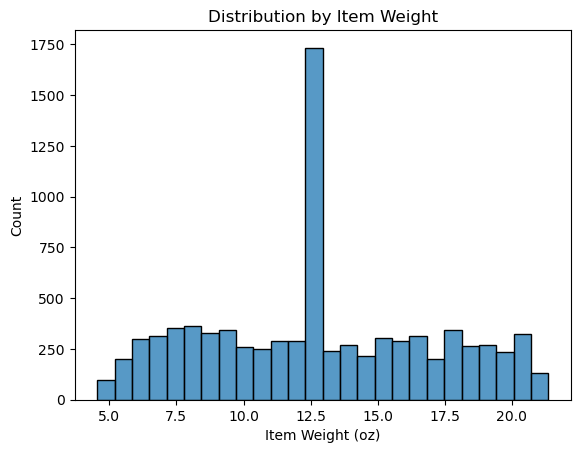

In [22]:
#Create a histogram for Item_Weight
ax = sns.histplot(data = df, x = 'Item_Weight');
ax.set_title('Distribution by Item Weight');
ax.set_xlabel('Item Weight (oz)');

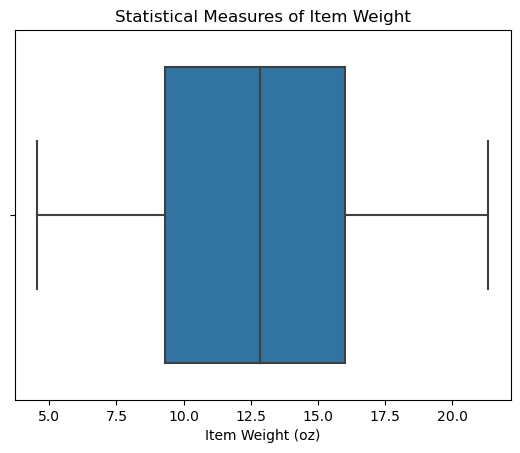

In [23]:
#Create boxplot of Item_Weight
ax = sns.boxplot(data = df, x = 'Item_Weight');
ax.set_title('Statistical Measures of Item Weight');
ax.set_xlabel('Item Weight (oz)');

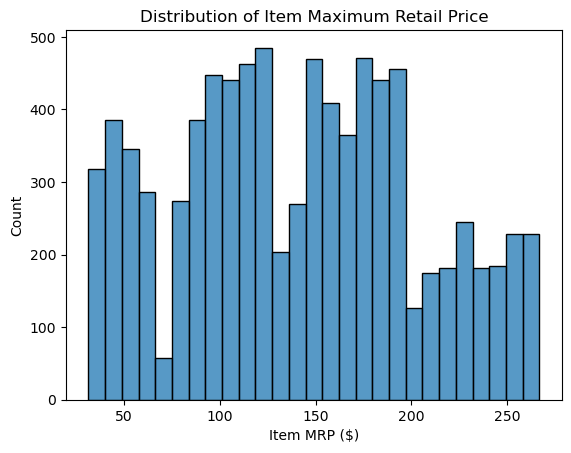

In [24]:
#Create a histogram of Item_MRP
ax = sns.histplot(data = df, x = 'Item_MRP')
ax.set_title('Distribution of Item Maximum Retail Price');
ax.set_xlabel('Item MRP ($)');

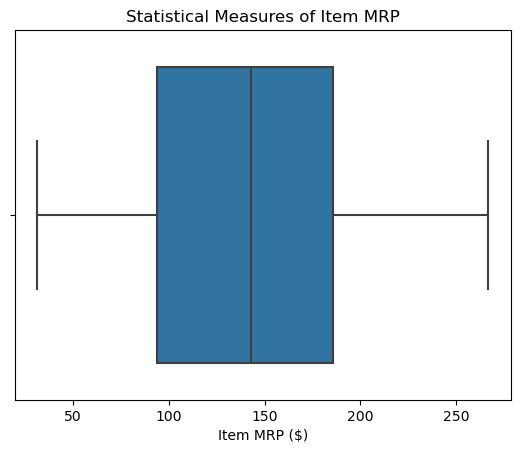

In [25]:
#Create a boxplot of Item_MRP
ax = sns.boxplot(data = df, x = 'Item_MRP')
ax.set_title("Statistical Measures of Item MRP");
ax.set_xlabel('Item MRP ($)');

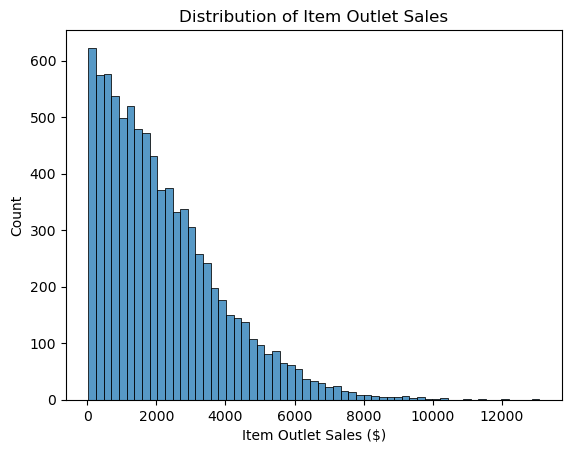

In [26]:
#Create a histogram for Item_Outlet_Sales
ax = sns.histplot(data = df, x = 'Item_Outlet_Sales');
ax.set(xlabel = 'Item Outlet Sales ($)', title = "Distribution of Item Outlet Sales");

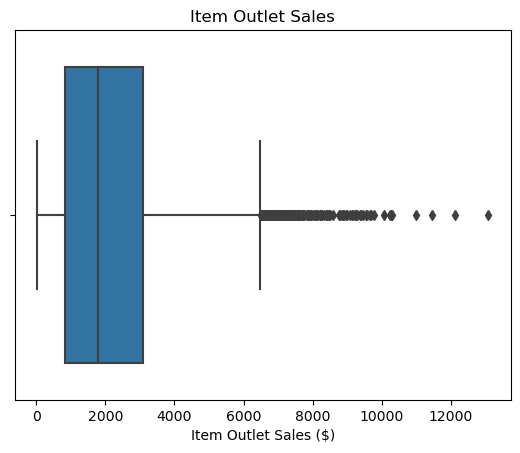

In [27]:
#Boxplot of Item_Outlet_Sales
ax = sns.boxplot(data = df, x = 'Item_Outlet_Sales')
ax.set(xlabel = 'Item Outlet Sales ($)', title = 'Item Outlet Sales');

## EDA for Categorical Columns
## Next, I will explore data from categorical columns using countplots.


In [28]:
#Get values counts
fat_content_counts = df['Item_Fat_Content'].value_counts()
fat_content_counts.index

Index(['Low Fat', 'Regular'], dtype='object')

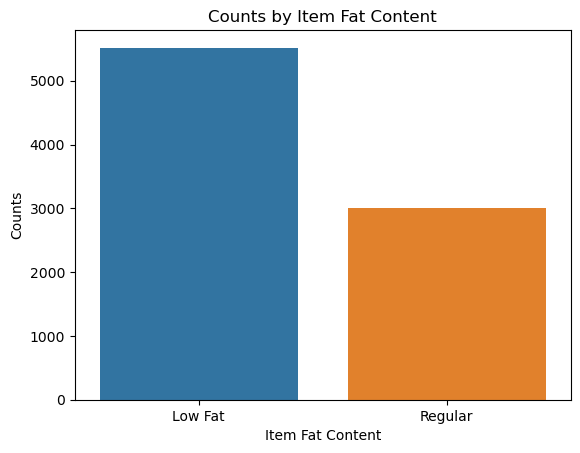

In [29]:
#Create countplot for Item_Fat_Content
ax = sns.countplot(data = df, x = 'Item_Fat_Content', order = fat_content_counts.index)
ax.set(xlabel = 'Item Fat Content', ylabel = 'Counts', title = 'Counts by Item Fat Content');

In [30]:
#Get value counts
item_counts = df['Item_Type'].value_counts()
item_counts.index

Index(['Fruits and Vegetables', 'Snack Foods', 'Household', 'Frozen Foods',
       'Dairy', 'Canned', 'Baking Goods', 'Health and Hygiene', 'Soft Drinks',
       'Meat', 'Breads', 'Hard Drinks', 'Others', 'Starchy Foods', 'Breakfast',
       'Seafood'],
      dtype='object')

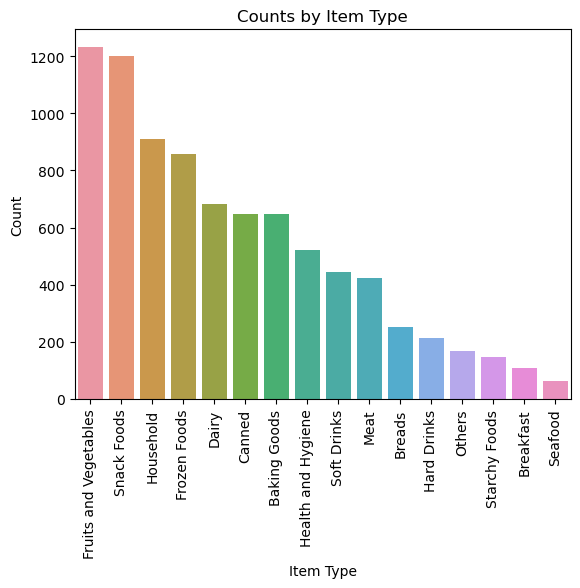

In [31]:
#Create countplot for Item_Type
ax = sns.countplot(data = df, x = 'Item_Type', order = item_counts.index);
ax.set(xlabel = 'Item Type', ylabel = 'Count', title = 'Counts by Item Type');
ax.tick_params(axis = 'x', rotation = 90);

From this countplot, we can see that the 4 top selling item types are Fruits and Vegetables, Snack Foods, Household, and Frozen Foods. Alternately, the 4 lowest selling item types are Seafood, Breakfast, Starchy Foods, and Others. This may help us to predict overall sales based on item type.

In [32]:
#Get value counts
outlet_ID = df['Outlet_Identifier'].value_counts()
outlet_ID.index



Index(['OUT027', 'OUT013', 'OUT049', 'OUT046', 'OUT035', 'OUT045', 'OUT018',
       'OUT017', 'OUT010', 'OUT019'],
      dtype='object')

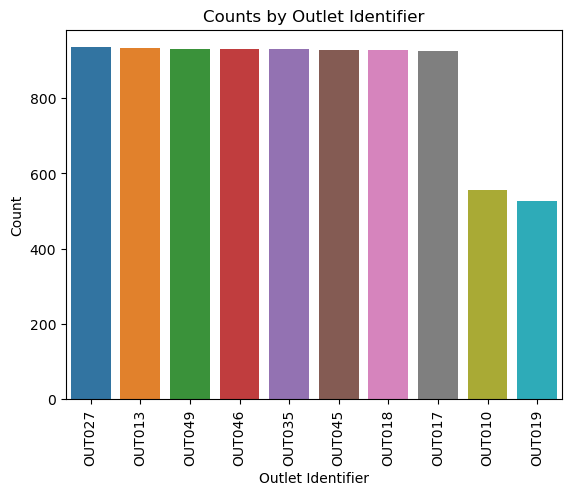

In [33]:
#Create countplot for Outlet_Identifier
ax = sns.countplot(data = df, x = 'Outlet_Identifier', order = outlet_ID.index);
ax.set(xlabel = 'Outlet Identifier', ylabel = 'Count', title = 'Counts by Outlet Identifier');
ax.tick_params(axis = 'x', rotation = 90);

In [34]:
#Get value counts for outlet size
size_counts = df['Outlet_Size'].value_counts()
size_counts.index

Index(['Medium', 'MISSING', 'Small', 'Large'], dtype='object')

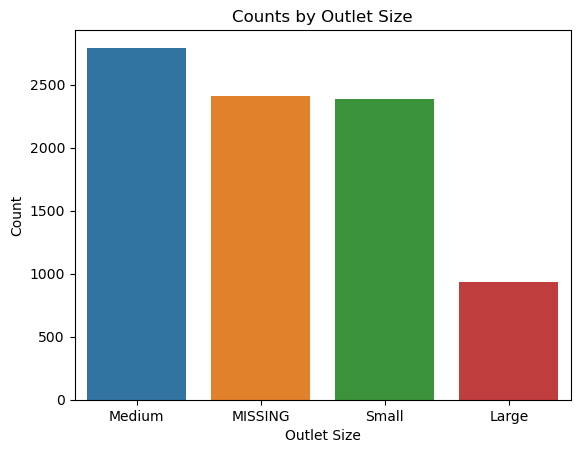

In [35]:
#Create countplot for Outlet_Size
ax = sns.countplot(data = df, x = 'Outlet_Size', order = size_counts.index);
ax.set(xlabel = 'Outlet Size', ylabel = 'Count', title = 'Counts by Outlet Size');

In [36]:
#Get value counts for location type
loc_type_counts = df['Outlet_Location_Type'].value_counts()
loc_type_counts.index

Index(['Tier 3', 'Tier 2', 'Tier 1'], dtype='object')

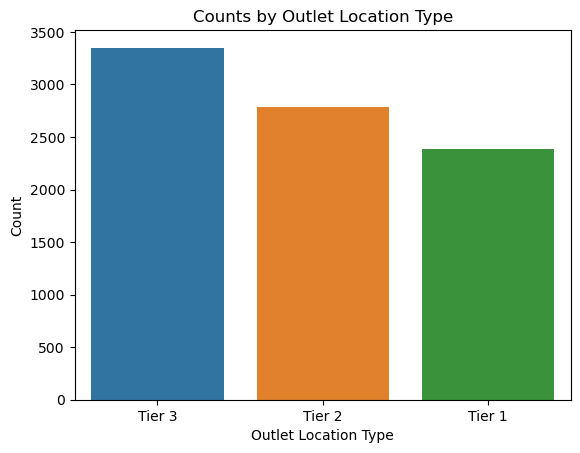

In [37]:
#Create countplot for Outlet_Location_Type
ax = sns.countplot(data = df, x = 'Outlet_Location_Type', order = loc_type_counts.index)
ax.set(xlabel = 'Outlet Location Type', ylabel = 'Count', title = 'Counts by Outlet Location Type');

In [38]:
#Get value counts for outlet type
type_counts = df['Outlet_Type'].value_counts()
type_counts.index

Index(['Supermarket Type1', 'Grocery Store', 'Supermarket Type3',
       'Supermarket Type2'],
      dtype='object')

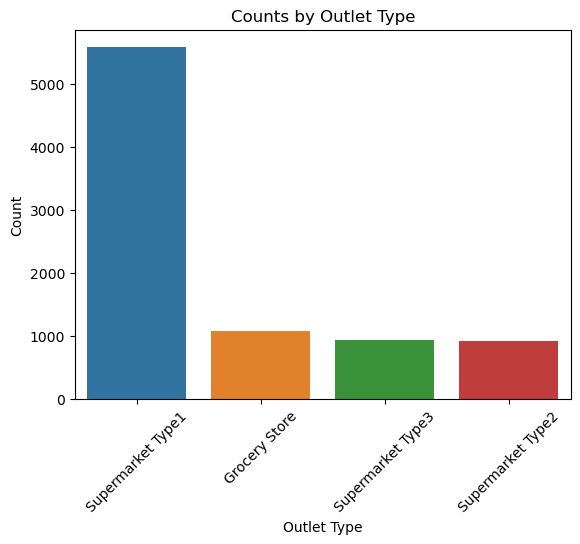

In [39]:
#Create countplot for Outlet_Type
ax = sns.countplot(data = df, x = 'Outlet_Type', order = type_counts.index);
ax.set(xlabel = 'Outlet Type', ylabel = 'Count', title = 'Counts by Outlet Type');
ax.tick_params(axis = 'x', rotation = 45);

In [40]:
#Get correlation values
corr = df.corr(numeric_only = True)
corr.round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.00,-0.01,0.02,-0.01,0.01
Item_Visibility,-0.01,1.00,-0.00,-0.07,-0.13
Item_MRP,0.02,-0.00,1.00,0.01,0.57
Outlet_Establishment_Year,-0.01,-0.07,0.01,1.00,-0.05
Item_Outlet_Sales,0.01,-0.13,0.57,-0.05,1.00


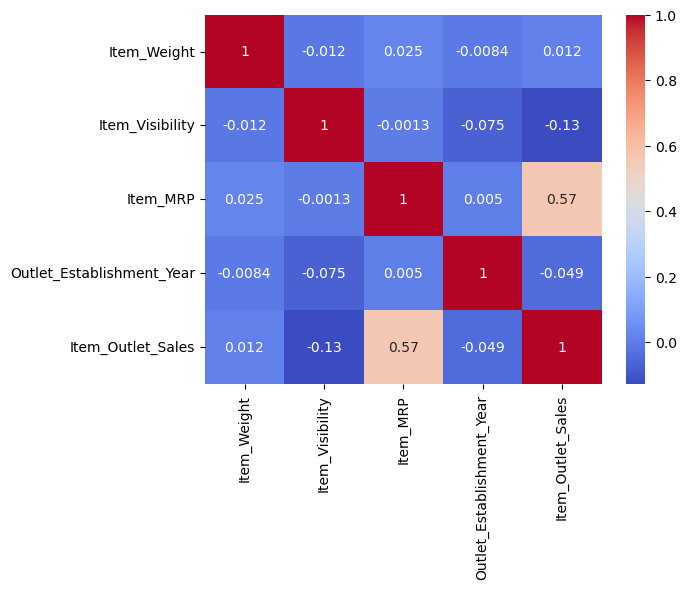

In [41]:
#Create heatmap
sns.heatmap(corr, cmap = 'coolwarm', annot = True);

In [42]:
# Basic imports for functions
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# UNIVARIATE PLOTTING FUNCTIONS FOR EDA
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):
  """Creates a seaborn countplot with the option to temporarily fill missing values
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}", fontweight='bold')

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")

  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100

  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax


def explore_numeric(df, x, figsize=(6,5) ):
  """Creates a seaborn histplot and boxplot with a share x-axis,
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """

  ## Save null value counts and percent for printing
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100


  ## Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])

  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])

  ## Adding a title
  axes[0].set_title(f"Column: {x}", fontweight='bold')

  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()


  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = df[x].nunique()
  print(f"- Unique Values: {nunique}")


  # Get the most most common value, its count as # and as %
  most_common_val_count = df[x].value_counts(dropna=False).head(1)
  most_common_val = most_common_val_count.index[0]
  freq = most_common_val_count.values[0]
  perc_most_common = freq / len(df) * 100

  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")

  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, axes

In [43]:
# Basic imports for functions
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

"""MULTIVARIATE PLOTTING FUNCTIONS VS. NUMERIC TARGET"""

def plot_categorical_vs_target(df, x, y='Item_Outlet_Sales',figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None):
  """Plots a combination of a seaborn barplot of means combined with
  a seaborn stripplot to show the spread of the data.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)

  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)

    # Barplot
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)

  # Boxplot
  sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)
  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

  # Add a title
  ax.set_title(f"{x} vs. {y}", fontweight='bold')
  fig.tight_layout()
  return fig, ax


def plot_numeric_vs_target(df, x, y='Item_Outlet_Sales',
                           figsize=(6,4)):
  """Plots a seaborn regplot with Pearson's correlation (r) added
  to the title.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Calculate the correlation
  corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]

  # Plot the data
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','lw':1,'alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws)

  ## Add the title with the correlation
  ax.set_title(f"{x} vs. {y} (r = {r})", fontweight='bold')

  # Make sure the plot is shown before the print statement
  plt.show()

  return fig, ax

In [44]:
#Replace placeholder values with Nan

#Item_Weight column
df['Item_Weight'] = df['Item_Weight'].replace(12.86, np.nan)

#Outlet_Size column
df['Outlet_Size'] = df['Outlet_Size'].replace('MISSING', np.nan)

In [45]:
#Verify changes were made
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [46]:
#Univariate EDA
#Comfirm data type for function call
feature = 'Item_Identifier'
df[feature].dtype

dtype('O')

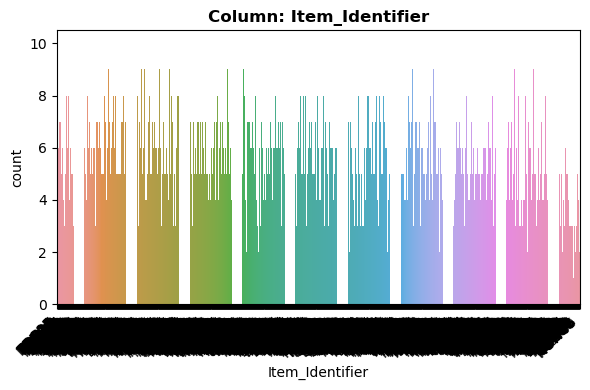

- NaN's Found: 0 (0.0%)
- Unique Values: 1559
- Most common value: 'FDW13' occurs 10 times (0.12%)
- Not constant or quasi-constant.


In [47]:
#Call explore categorical function
explore_categorical(df, feature);

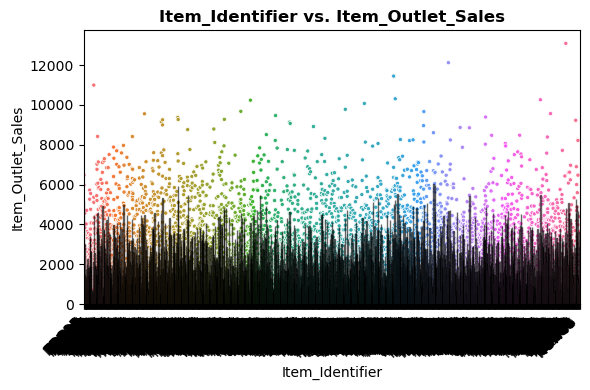

In [48]:
#Multivariate EDA
plot_categorical_vs_target(df, feature);

In [49]:
#Univariate EDA
#Comfirm data type for function call
feature1 = 'Item_Weight'
df[feature1].dtype

dtype('float64')

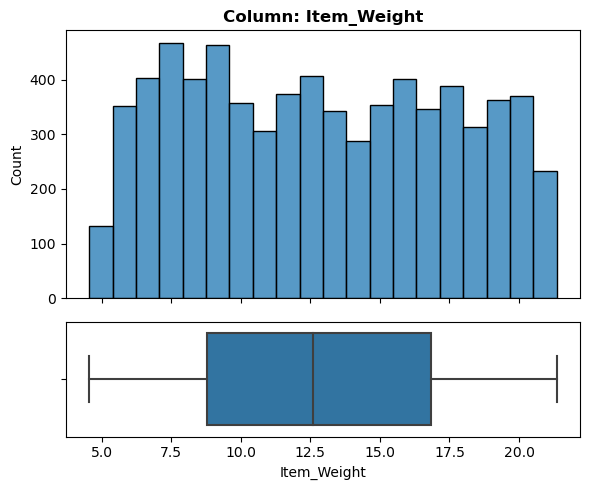

- NaN's Found: 1463 (17.17%)
- Unique Values: 415
- Most common value: 'nan' occurs 1463 times (17.17%)
- Not constant or quasi-constant.


In [50]:
#Call numeric function
explore_numeric(df, feature1);

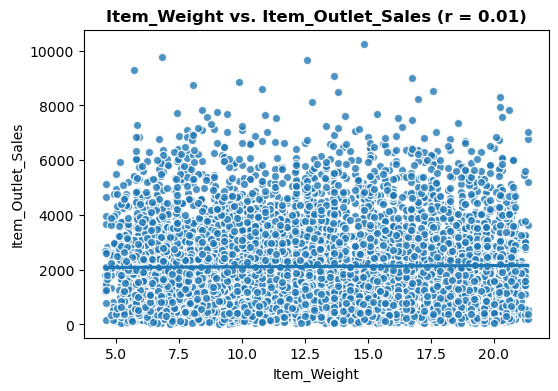

In [51]:
#Multivariate EDA
plot_numeric_vs_target(df, feature1);

In [52]:
#Univariate EDA
#Comfirm data type for function call
feature2 = 'Item_Fat_Content'
df[feature2].dtype

dtype('O')

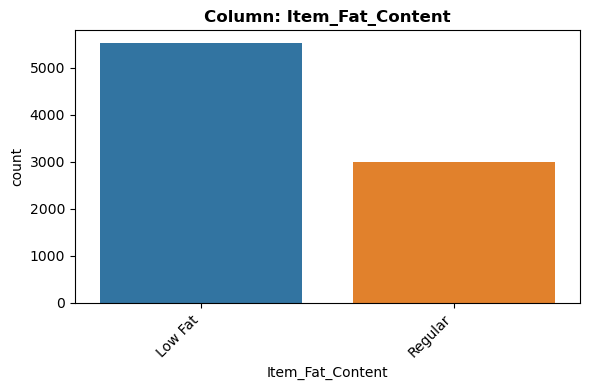

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'Low Fat' occurs 5517 times (64.73%)
- Not constant or quasi-constant.


In [53]:
#Call categorical function
explore_categorical(df, feature2);

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Item_Fat_Content vs. Item_Outlet_Sales'}, xlabel='Item_Fat_Content', ylabel='Item_Outlet_Sales'>)

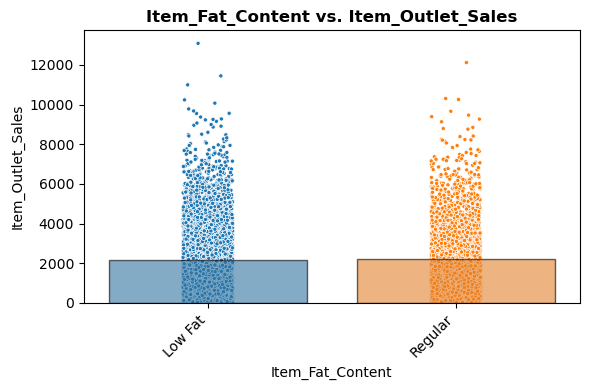

In [54]:
#Multivariate EDA
plot_categorical_vs_target(df, feature2)

In [55]:
#Univariate EDA
#Comfirm data type for function call
feature3 = 'Item_Visibility'
df[feature3].dtype

dtype('float64')

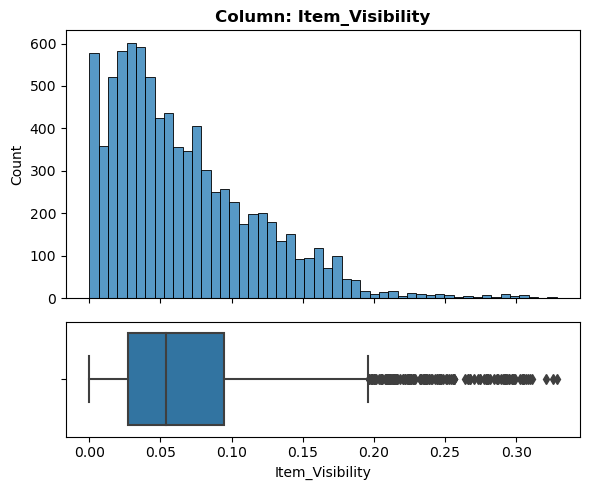

- NaN's Found: 0 (0.0%)
- Unique Values: 7880
- Most common value: '0.0' occurs 526 times (6.17%)
- Not constant or quasi-constant.


In [56]:
#Call numeric function
explore_numeric(df, feature3);

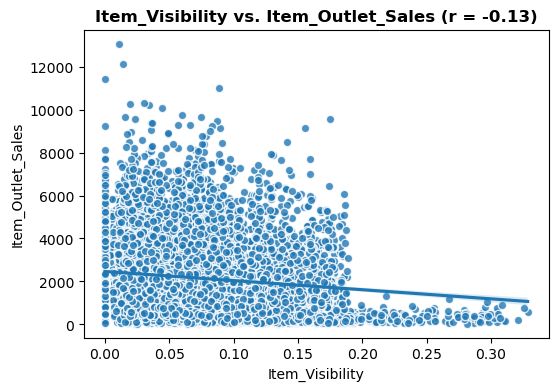

In [57]:
#Multivariate EDA
plot_numeric_vs_target(df, feature3);

In [58]:
#Univariate EDA
#Comfirm data type for function call
feature4 = 'Item_Type'
df[feature4].dtype

dtype('O')

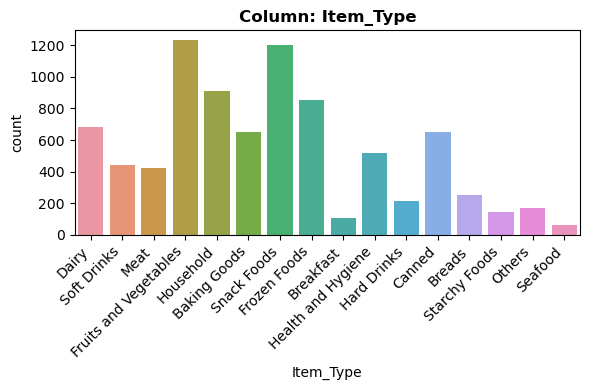

- NaN's Found: 0 (0.0%)
- Unique Values: 16
- Most common value: 'Fruits and Vegetables' occurs 1232 times (14.46%)
- Not constant or quasi-constant.


In [59]:
#Call categorical function
explore_categorical(df, feature4);

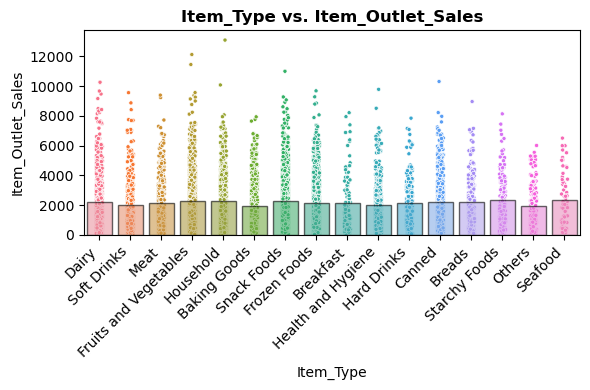

In [60]:
#Multivariate EDA
plot_categorical_vs_target(df, feature4);

In [61]:
#Univariate EDA
#Comfirm data type for function call
feature5 = 'Item_MRP'
df[feature5].dtype

dtype('float64')

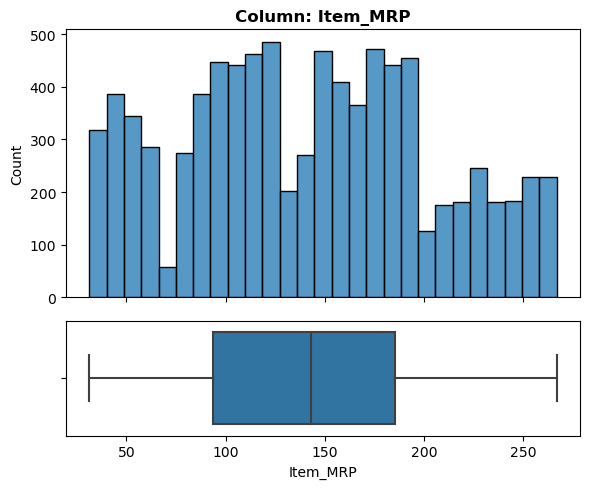

- NaN's Found: 0 (0.0%)
- Unique Values: 5938
- Most common value: '172.0422' occurs 7 times (0.08%)
- Not constant or quasi-constant.


In [62]:
#Call numeric function
explore_numeric(df, feature5);

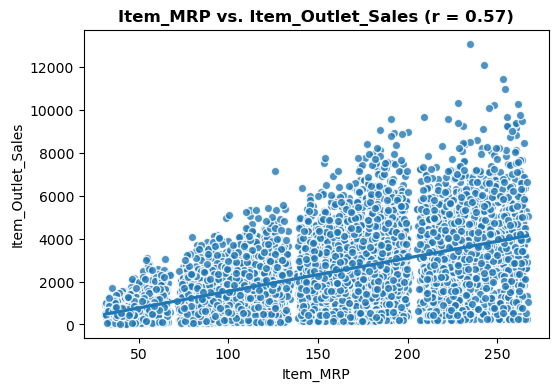

In [63]:
#Multivariate EDA
plot_numeric_vs_target(df, feature5);

In [64]:
#Univariate EDA
#Comfirm data type for function call
feature6 = 'Outlet_Identifier'
df[feature6].dtype

dtype('O')

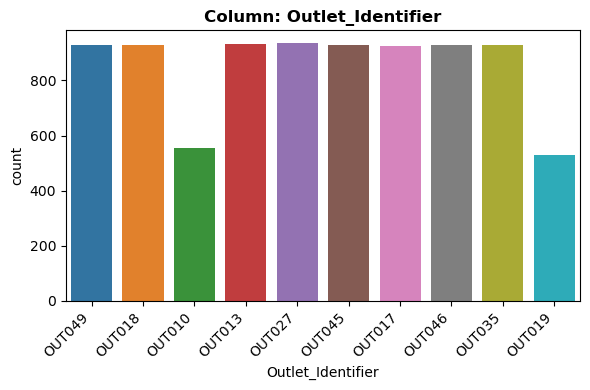

- NaN's Found: 0 (0.0%)
- Unique Values: 10
- Most common value: 'OUT027' occurs 935 times (10.97%)
- Not constant or quasi-constant.


In [65]:
#Call categorical function
explore_categorical(df, feature6);

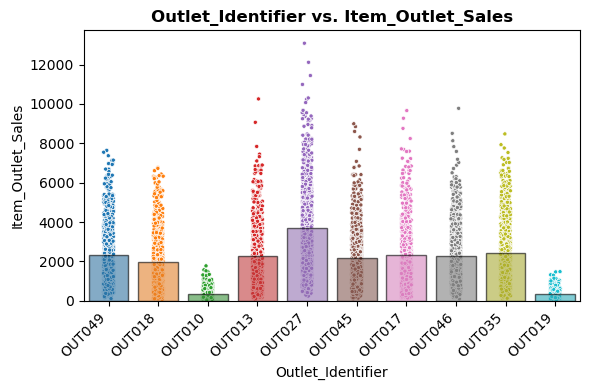

In [66]:
#Multivariate EDA
plot_categorical_vs_target(df, feature6);

In [67]:
#Univariate EDA
#Comfirm data type for function call
feature7 = 'Outlet_Establishment_Year'
df[feature7].dtype

dtype('int64')

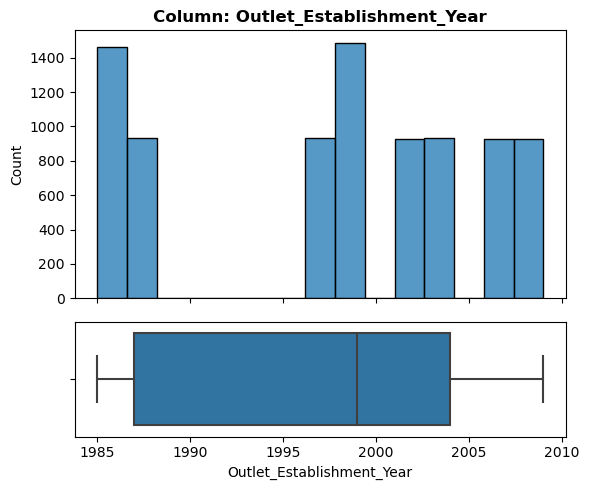

- NaN's Found: 0 (0.0%)
- Unique Values: 9
- Most common value: '1985' occurs 1463 times (17.17%)
- Not constant or quasi-constant.


In [68]:
#Call numeric function
explore_numeric(df, feature7);

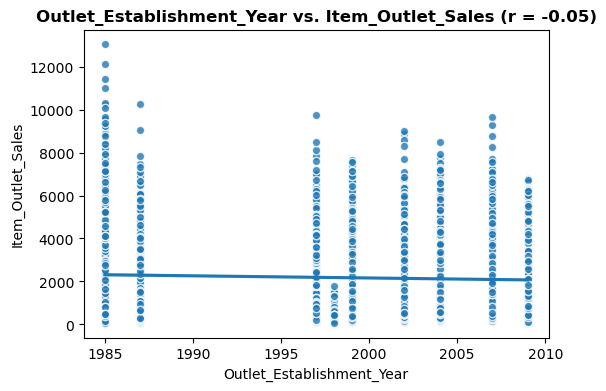

In [69]:
#Multivariate EDA
plot_numeric_vs_target(df, feature7);

In [70]:
#Univariate EDA
#Comfirm data type for function call
feature8 = 'Outlet_Size'
df[feature8].dtype

dtype('O')

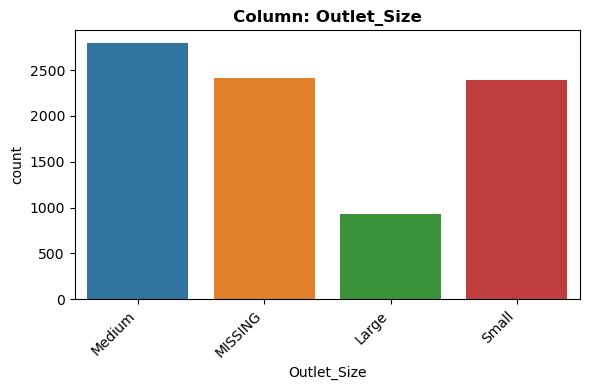

- NaN's Found: 2410 (28.28%)
- Unique Values: 4
- Most common value: 'Medium' occurs 2793 times (32.77%)
- Not constant or quasi-constant.


In [71]:
#Call categorical function
explore_categorical(df, feature8);

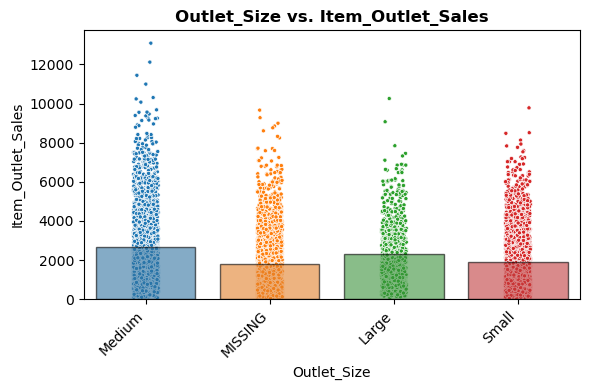

In [72]:
#Multivariate EDA
plot_categorical_vs_target(df, feature8);

In [73]:
#Univariate EDA
#Comfirm data type for function call
feature9 = 'Outlet_Location_Type'
df[feature9].dtype

dtype('O')

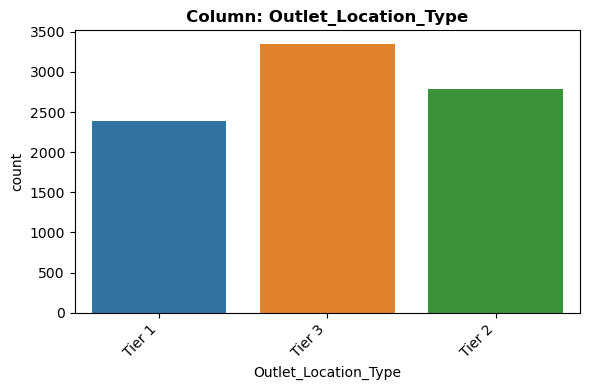

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: 'Tier 3' occurs 3350 times (39.31%)
- Not constant or quasi-constant.


In [74]:
#Call categorical function
explore_categorical(df, feature9);

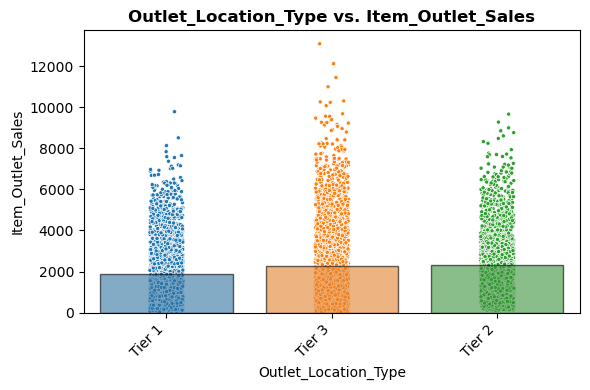

In [75]:
#Multivariate EDA
plot_categorical_vs_target(df, feature9);